In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import numpy as np 
import matplotlib.pyplot as plt  
%matplotlib inline 
from scipy.integrate import odeint
from sklearn import preprocessing

In [2]:
# load training data 
out_temp = np.load('RNN_data.npy')
inp_temp = np.load('inp.npy')


In [3]:
out_temp.shape

(536, 60, 300)

In [4]:
# Normalize data across the neurons
out = np.zeros(out_temp.shape)
scaler = preprocessing.StandardScaler()
for n in np.arange(536):
    slic = out_temp[n, :, :]
    a = scaler.fit_transform(slic)
    out[n, :,:] = a

In [5]:
np.var(out)

0.9047699004975117

In [6]:
out.shape

(536, 60, 300)

In [7]:
# Bin movie data
inp = np.zeros((300, inp_temp.shape[1]))
for i in np.arange(0,900,3):
    msum = (inp_temp[i, :] + inp_temp[i+1, :] + inp_temp[i+2, :]) / 3
    inp[int(i / 3), :] = msum

In [8]:
inp.shape

(300, 184832)

In [9]:
# construct NN
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(184832, 536) # input to layer 1
        self.fc2 = nn.Linear(536,536) # layer 1 to output
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

In [10]:
def get_train_batch(batch_size=10, dataset_size=300):
    batch_size = 10 
    id_list = np.random.choice(np.arange(300), batch_size)
    id_list2 = np.random.choice(np.arange(40), batch_size)
    
    k = 0
    
    inputs_list = []
    outputs_list = []
    for i in id_list:
        j = id_list2[k]
        inputs_list.append(inp[i][:].astype(np.float32))
        outputs_list.append(out[:,j,i].astype(np.float32))
    inputs_list = np.asarray(inputs_list)
    outputs_list = np.asarray(outputs_list)
    return inputs_list, outputs_list 

In [11]:
# initialize model 
model = Net()
model.train()

Net(
  (fc1): Linear(in_features=184832, out_features=536, bias=True)
  (fc2): Linear(in_features=536, out_features=536, bias=True)
)

In [12]:
# parameter 
learning_rate = 0.001 
num_epoch = 50
print_every= 5

loss_list = []

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i_epoch in range(num_epoch):
    
    # initialize optimizer 
    optimizer.zero_grad()
    
    # get inputs
    inputs_list, outputs_list = get_train_batch(batch_size=50)
    inputs = Variable(torch.from_numpy(inputs_list), requires_grad=True)
    outputs = Variable(torch.from_numpy(outputs_list), requires_grad=True)
    
    # get loss
    pred = model(inputs)
    loss = criterion(outputs, pred)
    loss_list.append(loss.data.cpu())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i_epoch+1)%print_every == 0:
        print("Current epoch: ", i_epoch+1, "; loss is: ", loss.data.cpu())
        

Current epoch:  5 ; loss is:  tensor(2.4861e+08)
Current epoch:  10 ; loss is:  tensor(0.7100)
Current epoch:  15 ; loss is:  tensor(0.7919)
Current epoch:  20 ; loss is:  tensor(0.7179)
Current epoch:  25 ; loss is:  tensor(1.3381)
Current epoch:  30 ; loss is:  tensor(0.9649)
Current epoch:  35 ; loss is:  tensor(1.0377)
Current epoch:  40 ; loss is:  tensor(0.7535)
Current epoch:  45 ; loss is:  tensor(0.8000)
Current epoch:  50 ; loss is:  tensor(0.6002)


In [13]:
inputs, labels = get_train_batch(batch_size=5)

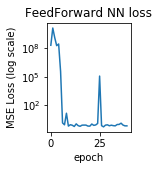

In [21]:
plt.figure(figsize=(1.5,2))
plt.semilogy(loss_list[0:40])
plt.xlabel('epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('FeedForward NN loss')
plt.savefig('loss.png', bbox_inches="tight")

In [15]:
# simulate with NN
out_test = out[:, 55, 3].astype(np.float32)
inp_test = inp[3, :].astype(np.float32)

In [16]:
print(out_test.shape)
print(inp_test.shape)

(536,)
(184832,)


In [17]:
inputs = Variable(torch.from_numpy(inp_test), requires_grad=False)
out_pred = model(inputs)

In [18]:
out_pred.shape

torch.Size([536])

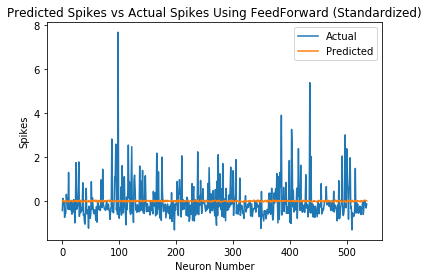

In [30]:
plt.plot(out_test)
plt.plot(out_pred.data.numpy())
plt.ylabel('Spikes')
plt.xlabel('Neuron Number')
plt.legend(['Actual', 'Predicted'])
plt.title('Predicted Spikes vs Actual Spikes Using FeedForward (Standardized)')
plt.savefig('predicted.png')

In [22]:
a = np.load('a.npy')

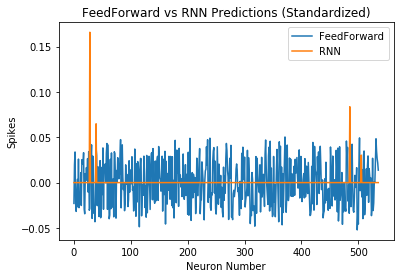

In [29]:
plt.plot(out_pred.data.numpy())
plt.plot(a.flatten())
plt.xlabel('Neuron Number')
plt.ylabel('Spikes')
plt.title('FeedForward vs RNN Predictions (Standardized)')
plt.legend(['FeedForward', 'RNN'])
plt.savefig('comparison.png')